In [2]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from IPython.display import HTML, Video,display
from csbdeep.utils import normalize
import numpy as np
import tifffile as tiff
import imageio.v3 as iio
from tqdm import tqdm
import re
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from src import *

/leonardo_scratch/fast/IscrC_MACRO/CalciumImagingDenoising/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DeepCAD-RT Training

ℹ️ This notebook visualizes the trainings made with [deepcad_train.py](deepcad_train.py).

Please refer to the script to run the training. The provided configuration run in about 1h on 3 A100 64GB GPUs.

## 1. Convert test video from TIFF to MP4

In [46]:
trainings = {
    # "1lf + .5hf + .0004tv": "astro_202508061541",
    # ".25lf + 1.5hf + .0004tv": "astro_202508061548",
    # ".25lf + 15hf": "astro_202508061620",
    # "15lf + .5hf + 1tv": "astro_202508061625",
    
    # ".5L1 + .5L2": "astro_202508061552",
    # ".5L1 + .5L2 - .00001Grad": "astro_202508061615",
    # ".5L1 + .5L2 - .0001Grad": "astro_202508061616",
    
    # "1 - SSIM": "astro_202508061632",
    
    "(DCT) .5L1 + .5L2": "astro_202508061748",
}

In [47]:
dir = Path("./pth/astro_202508061748")
prediction_dir = Path(f"results/{dir.parts[-1]}")
prediction_dir.mkdir(exist_ok=True)

for file in tqdm(sorted(dir.glob("*.tif"))):
    Recording(file).render(prediction_dir / f"{file.stem}.mp4")

100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


In [48]:
for name, t in trainings.items():
    file = sorted(Path(f"results/{t}").glob("*.mp4"))[-1]
    cprint("Showing", f"green:{name}", f"yellow:Epoch {file.stem.split('E_')[1].split('_')[0]}")
    display(Video(url=str(file)))

Showing (DCT) .5L1 + .5L2 Epoch 01


Results are completely black when changing footage from the train set.

## 2. Comparing training results with given baseline

In [ ]:
baseline_file=Path("../dataset/sample/deepcad/oabf_good_example.tiff")
prediction_file=list(prediction_dir.glob("*.mp4"))[-1]

In [54]:
baseline = tiff.imread(baseline_file)
baseline /= np.max(baseline)
baseline = normalize(baseline, 1, 99)
baseline = np.clip(baseline, max=1)

prediction = iio.imread(prediction_file).astype(np.float64)
prediction /= np.max(prediction)

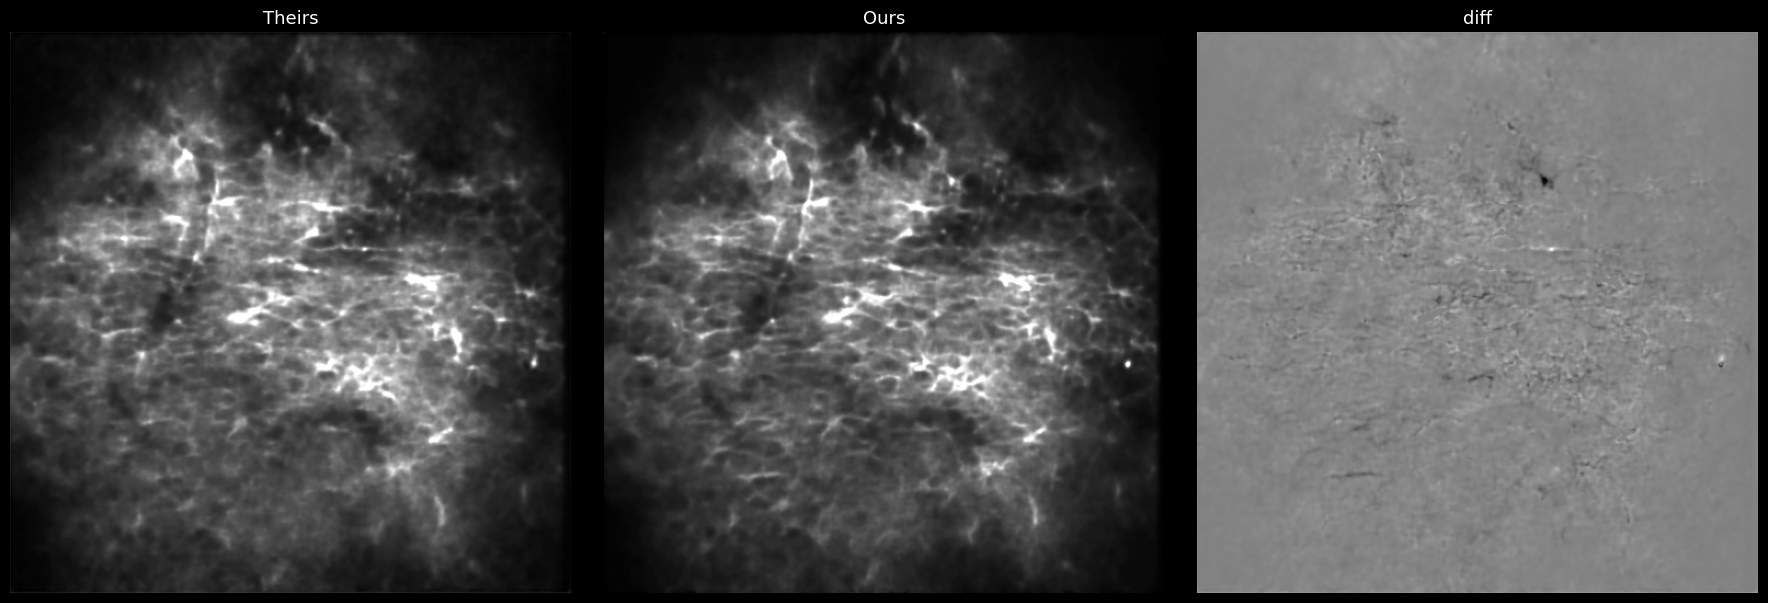

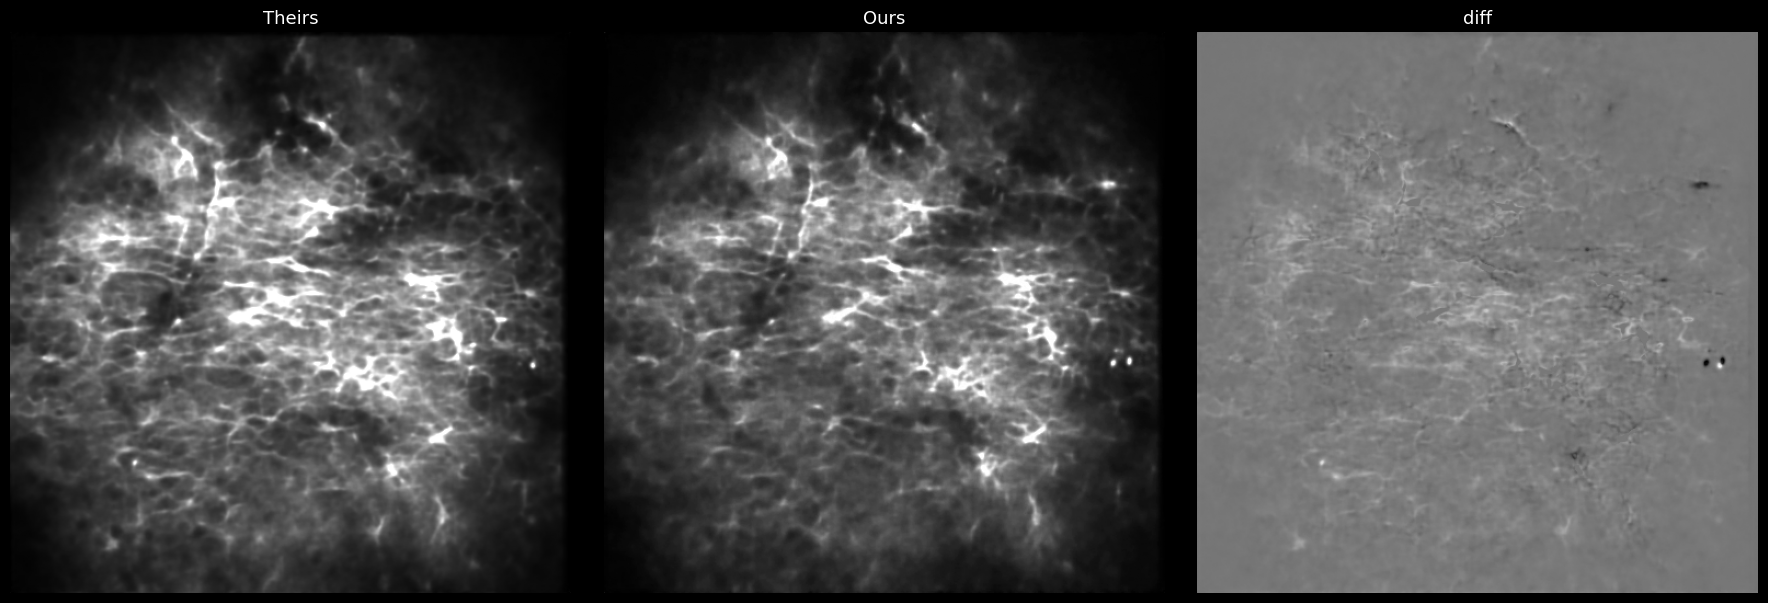

In [56]:
for frame in [0, -1]:
    imshow(
        {"Theirs": baseline[frame], "Ours": prediction[frame], "diff": baseline[frame] - prediction[frame, :, :, 0]},
        size=6,
        cmap="grey",
    )

Their deepCAD version can be improved with longer training.

## 3. Extract loss trend from logs

In [8]:
log_path = Path(f"results/2/log")

In [9]:
l1 = []
with open(log_path) as f:
    for line in tqdm(_ for _ in f.readlines() if "[Total loss:" in _):
        if match := re.search(r"L1 Loss: ([\d\.eE+-]+)", line):
            l1.append(float(match.group(1)))

20180it [00:00, 765449.01it/s]


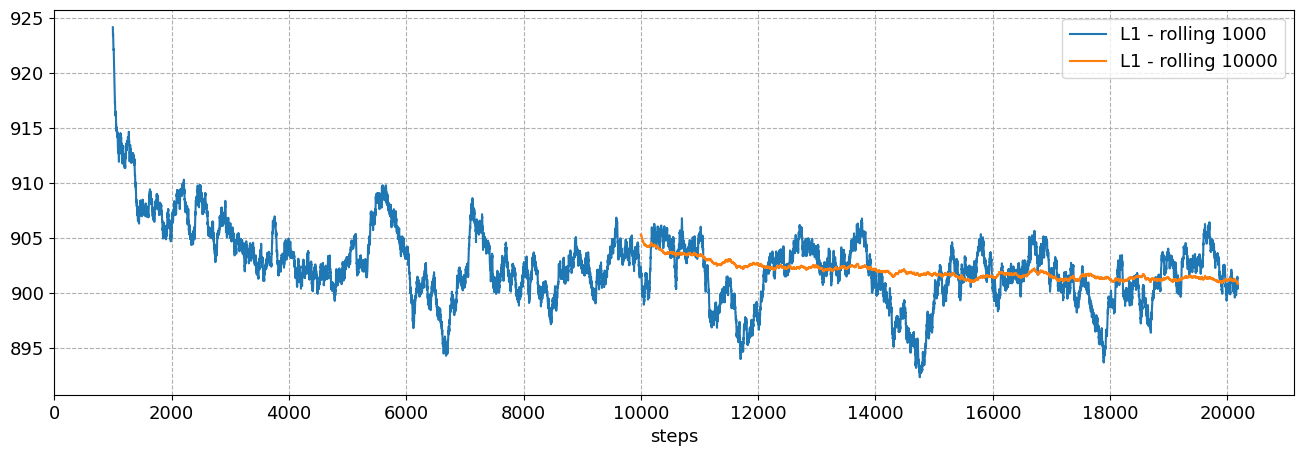

In [10]:
l1 = pd.Series(l1)
df = pd.DataFrame(
    {
        "steps": range(len(l1)),
        "L1 - rolling 1000": l1.rolling(1000).mean(),
        "L1 - rolling 10000": l1.rolling(10000).mean(),
    }
)
ax = df.plot(x="steps", figsize=(16, 5))
ax.set_xticks(range(0, len(df), 2000));